In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import ipopt

import warnings
warnings.filterwarnings("ignore")

/Users/alioth/opt/anaconda3/lib/python3.9/site-packages/ipopt/__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


In [2]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    weight_optimal = np.array([1/len(x_init)]*len(x_init)) # Equal weight = 1/n
    allocated_value = weight_optimal*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) # Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    
    n = len(x_init)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Minimize objective
    c  = [0.0] * n # No linear objective
    lb = [0.0] * n
    ub = [1.0] * n
    
    Atilde = []
    for k in range(n):
        Atilde.append([[0,1],[1,0]]) # One column of ones times corresponding weights
    
    var_names = ["w_%s" % i for i in range(1,n+1)] 
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")                  
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)
    
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] # Sparse matrix of Q
    cpx.objective.set_quadratic(qmat) # Quadratic objective
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    weight_optimal = np.array(cpx.solution.get_values())
    
    allocated_value = weight_optimal*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) #Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    
    n = len(x_init)+1
    r_rf = 0.025
    daily_rf = r_rf/252
    diff = mu - daily_rf
    
    coe_k = np.zeros((len(x_init),1))
    Q = np.hstack((Q,coe_k))
    coe_k = np.zeros((1,len(x_init)+1))
    Q = np.vstack((Q,coe_k)) # New row and column for risk free asset
    
    Atilde = []
    for k in range(len(x_init)):
        Atilde.append([[0,1],[diff[k],1]])
    Atilde.append([[0,1],[0,-1]]) 
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n 
    
    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=Atilde,names=var_names)

    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat) # Quadratic objective
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_maxSharpe = np.array(cpx.solution.get_values()) # Optimal weight                        
    weight = w_maxSharpe[0:len(x_init)]/w_maxSharpe[len(x_init)]
    
    allocated_value = weight*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) # Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [6]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            #  use finite differences to check the gradient
            for i in range(n):
                for j in range(n):
                    diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    delta_g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + delta_g
                grad[i] = 2 * 2 * grad[i]
            return grad

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n
    
        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
    
    n = len(x_init)
    w0 = (x_init*cur_prices)/portfolio_value # initial weight distribution
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    
    
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    w_optimal, info = nlp.solve(w0)
    
    allocated_money = w_optimal * portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_fee #cash = asset - stock value- transaction cost
 
    return x_optimal, cash_optimal

In [7]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    n = len(x_init)
    w0 = [1/n]*n                                         # Weight distribution for 1/n portfolio
    var_matr = np.diag(np.diag(Q))                           # Required portfolio robustness
    rob_init = np.dot(w0, np.dot(var_matr, w0))              # return estimation error of 1/n portfolio
    rob_bnd  = rob_init                                      # Target portfolio return estimation error is return estimation error of 1/n portfolio
    r_rf = 0.025
    daily_rf = r_rf/252
    Portf_Retn = daily_rf                                  
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    Atilde = []
    for k in range(n):
        Atilde.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_rMV = cpx.solution.get_values()
    # Round near-zero portfolio weights
    w_rMV = np.array(w_rMV)
    w_rMV[w_rMV<1e-6] = 0
    w_optimal = w_rMV / np.sum(w_rMV)
    
    allocated_money = w_optimal*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 # Convert weight optimal to postion optimal(x_optimal
    transaction_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005                #0.5% of transaction cost
    cash_optimal = portfolio_value - np.dot(x_optimal,cur_prices) - transaction_fee #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal

In [8]:
input_file_prices = ['Healthcare.csv', 'Agriculture.csv', 'Finance.csv', 'Technology.csv','All_stock.csv']
# df_healthcare = pd.read_csv('Healthcare.csv')
# df_agriculture = pd.read_csv('Agriculture.csv')
# df_finance = pd.read_csv('Finance.csv')
# df_technology = pd.read_csv('Technology.csv')
# df = [df_healthcare, df_agriculture, df_finance, df_technology]
# from functools import reduce
# df = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), df)

In [9]:
def get_portfolio(num, cur_cash):
    print('Data is from {}'.format(input_file_prices[num]))
    input_file = input_file_prices[num]
    df = pd.read_csv(input_file)
    
    data_prices = df.iloc[:, 1:].to_numpy()
    cur_returns0 = data_prices[1:,:] / data_prices[:-1,:] - 1
    mu = np.mean(cur_returns0, axis = 0)
    Q = np.cov(cur_returns0.T)
    
    init_positions = np.ones(df.shape[1]-1)
    
    # Initial value of the portfolio
    init_value = np.dot(data_prices[0,:], init_positions)

    # Initial portfolio weights
    w_init = (data_prices[0,:] * init_positions) / init_value
    
    # Number of assets
    N = len(df.columns)-1

    # Annual risk-free rate for years 2020-2021 is 2.5%
    r_rf = 0.025

    # Number of strategies
    strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 
                          'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_robust_optim']
    strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 
                          'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

    N_strat = len(strategy_functions)  
    fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, 
                strat_max_Sharpe, strat_equal_risk_contr, strat_robust_optim]

    portf_value = [0] * N_strat
    w_opt = np.zeros((N_strat,1),  dtype=np.ndarray)
    x = np.zeros((N_strat,1),  dtype=np.ndarray)
    cash = np.zeros((N_strat,1),  dtype=np.ndarray)

    cur_prices = data_prices[-1,:]

    for strategy  in range(N_strat):
        period = 1
        curr_cash = cur_cash #需要到时候user自己输入
      
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](init_positions, curr_cash, mu, Q, cur_prices)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        if cash[strategy, period-1] < 0:
            portfolio_V = np.dot(cur_prices,init_positions) + curr_cash
            
            ratio = x[strategy, period-1]/sum(x[strategy, period-1])
            neg_cash = abs(cash[strategy][period-1])*ratio
            neg_position = np.ceil(neg_cash/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - neg_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-init_positions)) * 0.005
            cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
        # Compute portfolio value
        p_values = np.dot(data_prices, x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy] = np.reshape(p_values, (p_values.size,1))
        w_opt[strategy][period-1] = x[strategy, period-1] *cur_prices / np.dot(cur_prices,x[strategy, period-1])
#         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
#              portf_value[strategy][0][0], portf_value[strategy][-1][0]),'\n')
#         print('  Strategy "{0}", optimal weight = "{1}"'.format( strategy_names[strategy], 
#              w_opt[strategy][0]),'\n')
    return df, portf_value, w_opt

In [17]:
# import sys
# sys.stdout=open("output.txt","w")
df, p , w = get_portfolio(0,0)
# sys.stdout.close()

Data is from Healthcare.csv
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       15
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7602571e-08 0.00e+00 3.78e-07   0.0 0.00e+

In [18]:
risk_dict = {"Low": ['Buy and Hold','Mininum Variance Portfolio'],
            "Medium": ['Equally Weighted Portfolio','Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio'],
            "High":['Maximum Sharpe Ratio Portfolio']}

In [24]:
def get_strategy (portf_value, key):
    strategy_list = risk_dict[key]
    strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 
                    'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 
                      'Robust Optimization Portfolio']

    index_list = [strategy_names.index(strategy) for strategy in strategy_list]
    
    for i in index_list:
        print("The strategy:",strategy_names[i]," , the portfolio value is: {:.4f}".format(portf_value[i][-1][0]))
    
    ind = np.argmax([portf_value[index_list[i]][-1][0] for i in range(len(index_list))])
    print('\n')
    print("The strategy with the highest return is: ", strategy_list[ind])
    
    return strategy_names.index(strategy_list[ind])

In [25]:
ind = get_strategy(p,"Medium")

The strategy: Equally Weighted Portfolio  , the portfolio value is: 2514.6217
The strategy: Equal Risk Contributions Portfolio  , the portfolio value is: 2514.0426
The strategy: Robust Optimization Portfolio  , the portfolio value is: 2511.0323


The strategy with the highest return is:  Equally Weighted Portfolio


In [27]:
def draw_plot(df,strategy,w_opt):
    
    index_lst = np.where(w_opt[strategy][0] != 0)[0]
    
    strategy_names= ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 
                     'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 
                     'Robust Optimization Portfolio']
    
    fig = plt.figure(figsize=(8,8))
    cmap= plt.get_cmap('tab20c')
    outer_colors = cmap(np.arange(15))
    
    plt.text(0, 1.2, strategy_names[strategy], fontsize=18, fontweight='bold',  horizontalalignment='center')
    
    plt.pie(x=w_opt[strategy][0][index_lst], colors=outer_colors, wedgeprops=dict(width=0.3),autopct='%1.1f%%')
    
    plt.legend(df.columns.values[1:][index_lst], loc="upper center", bbox_to_anchor=(-1, 1))

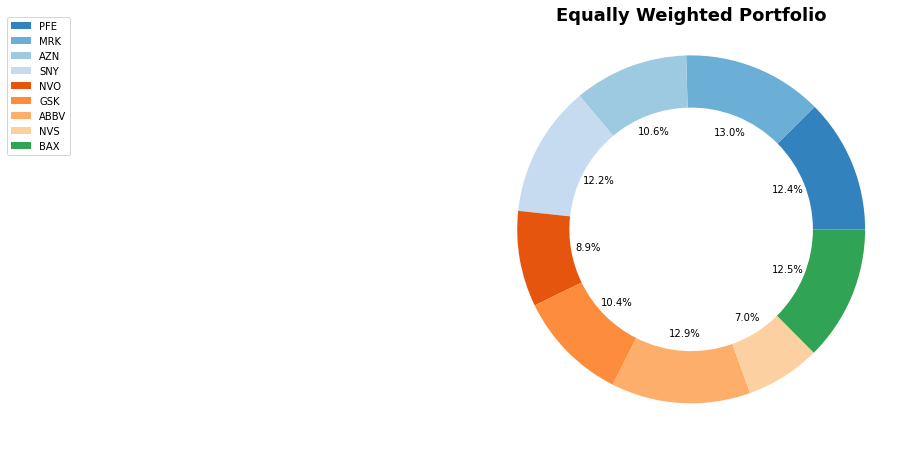

In [28]:
draw_plot(df,ind,w)